E0 — Montaje y rutas

In [1]:
# Versión de runtime y librerías
!nvidia-smi || echo "Sin GPU"
import sys, platform
print("Python:", platform.python_version())
!pip -q install timm==1.0.10 opencv-python==4.10.0.84 albumentations==1.4.8 grad-cam==1.5.8

# Montar Drive
from google.colab import drive
drive.mount('/content/drive')

# Definir rutas
from pathlib import Path

ROOT = Path('/content/drive/MyDrive/IA')

DIR_PRESENT = ROOT/'Glaucoma'/'Present'
DIR_NOTPRES = ROOT/'Glaucoma'/'Not_Present'

for p in [DIR_PRESENT, DIR_NOTPRES]:
    print(p, "OK?", p.exists())

Mon Nov 10 18:22:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

E1 — Chequeo del dataset + conteos + muestra rápida

Present (RD): 394  |  Not present: 309  | Total: 703


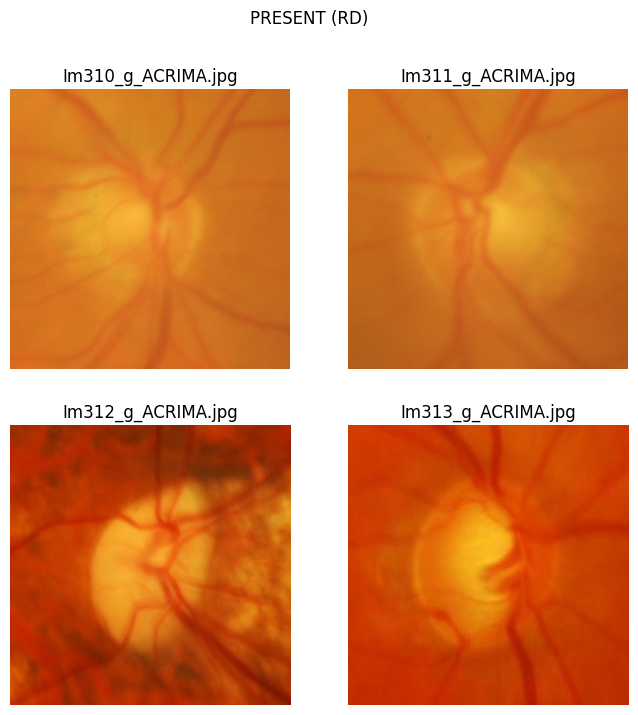

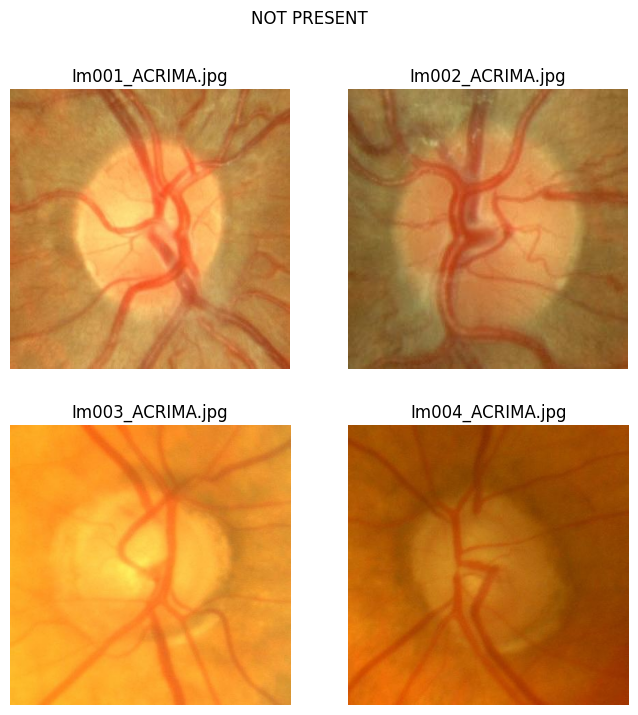

In [2]:
import os, glob
from PIL import Image
import matplotlib.pyplot as plt

def list_images(folder):
    exts = ('*.png','*.jpg','*.jpeg','*.bmp','*.tif','*.tiff')
    files = []
    for e in exts:
        files += glob.glob(os.path.join(folder, e))
    return sorted(files)

pos = list_images(str(DIR_PRESENT))
neg = list_images(str(DIR_NOTPRES))

print(f"Present (RD): {len(pos)}  |  Not present: {len(neg)}  | Total: {len(pos)+len(neg)}")

def show_grid(paths, title):
    n = min(4, len(paths))
    if n == 0:
        print("No hay imágenes en:", title);
        return
    plt.figure(figsize=(8,8))
    for i,p in enumerate(paths[:n], 1):
        try:
            img = Image.open(p).convert('RGB')
            plt.subplot(2,2,i); plt.imshow(img); plt.axis('off'); plt.title(os.path.basename(p)[:32])
        except Exception as e:
            print("Error con", p, e)
    plt.suptitle(title); plt.show()

show_grid(pos, "PRESENT (RD)")
show_grid(neg, "NOT PRESENT")

E2 — Pipeline ROI clásico + realce (fundus-centric)

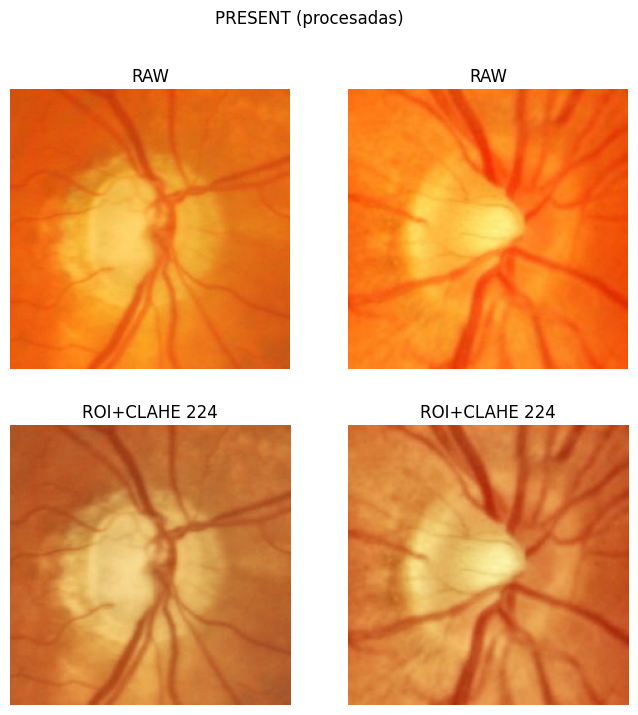

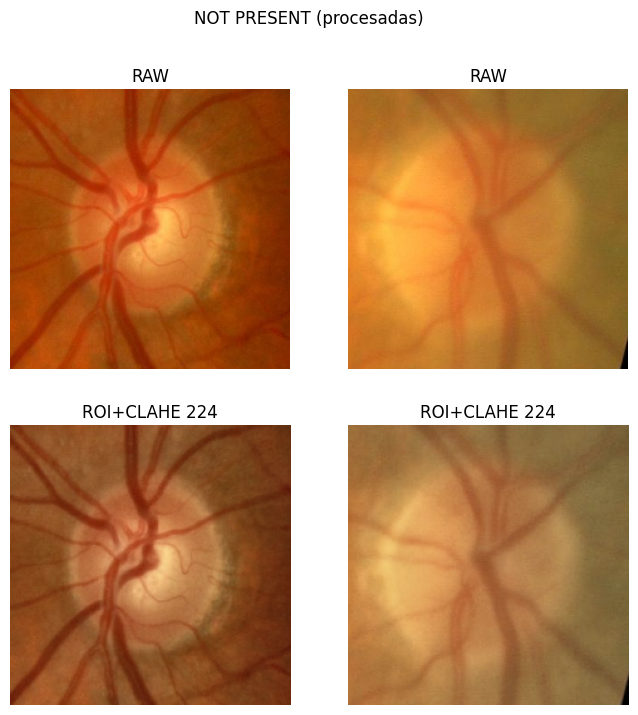

In [3]:
import cv2
import numpy as np
from PIL import Image
import random, matplotlib.pyplot as plt

def fundus_mask(img_bgr):

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (0, 0), 7)

    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = 255 - mask

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num > 1:
        largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = (labels == largest).astype(np.uint8) * 255
    return mask


def crop_to_mask(img_bgr, mask):

    ys, xs = np.where(mask > 0)
    h, w = img_bgr.shape[:2]
    if len(xs) == 0 or len(ys) == 0:
        return img_bgr
    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    crop_w, crop_h = x2 - x1, y2 - y1

    if crop_w < 0.6 * w or crop_h < 0.6 * h:
        return img_bgr

    mx, my = int(0.02 * w), int(0.02 * h)
    x1, y1 = max(0, x1 - mx), max(0, y1 - my)
    x2, y2 = min(w, x2 + mx), min(h, y2 + my)
    crop = img_bgr[y1:y2, x1:x2]
    return crop

def enhance_green(img_bgr):

    g = img_bgr[:, :, 1].astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=1.6, tileGridSize=(8, 8))
    g2 = clahe.apply(g)

    blur = cv2.GaussianBlur(g2, (0, 0), 1.3)
    sharp = cv2.addWeighted(g2, 1.2, blur, -0.2, 0)

    b, g, r = cv2.split(img_bgr)
    merged = cv2.merge([
        cv2.addWeighted(b, 0.7, sharp, 0.3, 0),
        cv2.addWeighted(g, 0.7, sharp, 0.3, 0),
        cv2.addWeighted(r, 0.7, sharp, 0.3, 0)
    ])
    return merged

def preprocess_fundus(img_pil, out_size=224):

    img_bgr = cv2.cvtColor(np.array(img_pil.convert('RGB')), cv2.COLOR_RGB2BGR)
    mask = fundus_mask(img_bgr)
    cropped = crop_to_mask(img_bgr, mask)
    enhanced = enhance_green(cropped)

    h, w = enhanced.shape[:2]
    side = max(h, w)
    canvas = np.zeros((side, side, 3), dtype=np.uint8)
    y0, x0 = (side - h) // 2, (side - w) // 2
    canvas[y0:y0 + h, x0:x0 + w] = enhanced

    resized = cv2.resize(canvas, (out_size, out_size), interpolation=cv2.INTER_AREA)
    return cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

samples_pos = random.sample(pos, k=min(2, len(pos))) if len(pos) > 0 else []
samples_neg = random.sample(neg, k=min(2, len(neg))) if len(neg) > 0 else []

for title, paths in [("PRESENT (procesadas)", samples_pos),
                     ("NOT PRESENT (procesadas)", samples_neg)]:
    if not paths:
        print("Sin muestras para", title)
        continue
    plt.figure(figsize=(8, 8))
    for i, pth in enumerate(paths, 1):
        raw = Image.open(pth).convert('RGB')
        pre = preprocess_fundus(raw, out_size=224)
        plt.subplot(2, 2, i)
        plt.imshow(raw)
        plt.axis('off')
        plt.title("RAW")
        plt.subplot(2, 2, i + 2)
        plt.imshow(pre)
        plt.axis('off')
        plt.title("ROI+CLAHE 224")
    plt.suptitle(title)
    plt.show()

E3 — Dataset y DataLoader (binario balanceado)

Train: 562 | Val: 141
✅ DataLoaders creados correctamente


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Batch shape: torch.Size([16, 3, 224, 224]) | Labels: [1, 1, 1, 1, 1, 0, 1, 0]


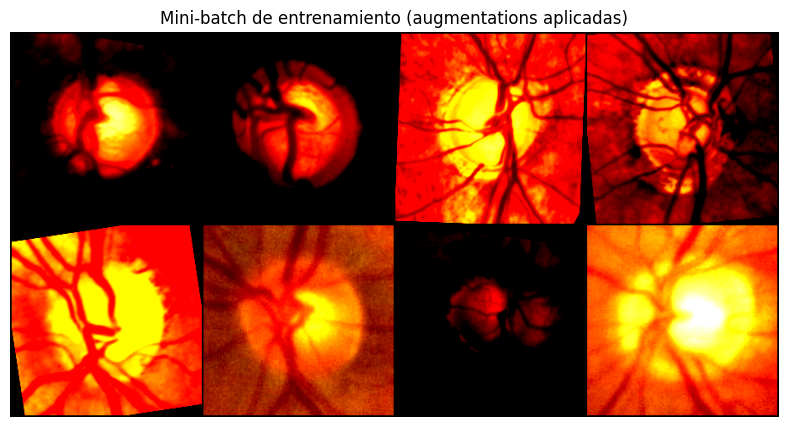

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

all_imgs = [(p, 1) for p in pos] + [(p, 0) for p in neg]
paths, labels = zip(*all_imgs)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.2, stratify=labels, random_state=42
)

print(f"Train: {len(train_paths)} | Val: {len(val_paths)}")

train_tfms = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.9, 1.1), p=0.8),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

class FundusDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        img = Image.open(img_path).convert('RGB')
        img = preprocess_fundus(img, out_size=224)
        img_np = np.array(img)
        if self.transform:
            img_np = self.transform(image=img_np)['image']
        return img_np, label


train_dataset = FundusDataset(train_paths, train_labels, transform=train_tfms)
val_dataset = FundusDataset(val_paths, val_labels, transform=val_tfms)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(" DataLoaders creados correctamente")

import torchvision.utils as vutils

batch_imgs, batch_lbls = next(iter(train_loader))
print("Batch shape:", batch_imgs.shape, "| Labels:", batch_lbls[:8].tolist())

grid = vutils.make_grid(batch_imgs[:8], nrow=4, normalize=True, value_range=(0,1))
plt.figure(figsize=(10,5))
plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
plt.axis('off')
plt.title("Mini-batch de entrenamiento (augmentations aplicadas)")
plt.show()


E4 — Entrenamiento completo DenseNet-121 (full fine-tuning)

Usando dispositivo: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]


 Epoch 1/25


Train Loss: 0.6809 | Val Loss: 0.6439
Acc: 0.6099 | Prec: 0.7500 | Rec: 0.4557 | F1: 0.5669 | AUC: 0.7493
Mejor modelo actualizado y guardado en /content/drive/MyDrive/IA/best_model_H2_Glaucoma.pth

 Epoch 2/25


Train Loss: 0.6254 | Val Loss: 0.5953
Acc: 0.6738 | Prec: 0.8837 | Rec: 0.4810 | F1: 0.6230 | AUC: 0.8359
Mejor modelo actualizado y guardado en /content/drive/MyDrive/IA/best_model_H2_Glaucoma.pth

 Epoch 3/25


Train Loss: 0.5734 | Val Loss: 0.5559
Acc: 0.7730 | Prec: 0.8983 | Rec: 0.6709 | F1: 0.7681 | AUC: 0.8865
Mejor modelo actualizado y guardado en /content/drive/MyDrive/IA/best_model_H2_Glaucoma.pth

 Epoch 4/25


Train Loss: 0.5165 | Val Loss: 0.5194
Acc: 0.8014 | Prec: 0.9474 | Rec: 0.6835 | F1: 0.7941 | AUC: 0.9238
Mejor modelo actualizado y guardado en /content/drive/MyDrive/IA/best_model_H2_Glaucoma.pth

 Epoch 5/25


Train Loss: 0.4956 | Val Loss: 0.4795
Acc: 0.8369 | Prec: 0.9516 | Rec: 0.7468 | F1: 0.8369 | AUC: 0.9377
Mejor modelo actualizado y guardado en /content/drive/MyDrive/IA/best_model_H2_Glaucoma.pth

 Epoch 6/25


Train Loss: 0.4608 | Val Loss: 0.4763
Acc: 0.8298 | Prec: 1.0000 | Rec: 0.6962 | F1: 0.8209 | AUC: 0.9479
Mejor modelo actualizado y guardado en /content/drive/MyDrive/IA/best_model_H2_Glaucoma.pth

 Epoch 7/25


Train Loss: 0.4499 | Val Loss: 0.4582
Acc: 0.8511 | Prec: 0.9531 | Rec: 0.7722 | F1: 0.8531 | AUC: 0.9412
Mejor modelo actualizado y guardado en /content/drive/MyDrive/IA/best_model_H2_Glaucoma.pth

 Epoch 8/25


Train Loss: 0.4326 | Val Loss: 0.4393
Acc: 0.8936 | Prec: 0.9706 | Rec: 0.8354 | F1: 0.8980 | AUC: 0.9475
Mejor modelo actualizado y guardado en /content/drive/MyDrive/IA/best_model_H2_Glaucoma.pth

 Epoch 9/25


Train Loss: 0.4113 | Val Loss: 0.4449
Acc: 0.8582 | Prec: 0.9836 | Rec: 0.7595 | F1: 0.8571 | AUC: 0.9555

 Epoch 10/25


Train Loss: 0.4200 | Val Loss: 0.4403
Acc: 0.8511 | Prec: 0.9265 | Rec: 0.7975 | F1: 0.8571 | AUC: 0.9453

 Epoch 11/25


Train Loss: 0.4107 | Val Loss: 0.4402
Acc: 0.8582 | Prec: 0.9403 | Rec: 0.7975 | F1: 0.8630 | AUC: 0.9516

 Epoch 12/25


Train Loss: 0.4147 | Val Loss: 0.4504
Acc: 0.8723 | Prec: 1.0000 | Rec: 0.7722 | F1: 0.8714 | AUC: 0.9535

 Epoch 13/25


Train Loss: 0.4045 | Val Loss: 0.4428
Acc: 0.8652 | Prec: 0.9688 | Rec: 0.7848 | F1: 0.8671 | AUC: 0.9569
⏹Early stopping activado.

Entrenamiento finalizado.


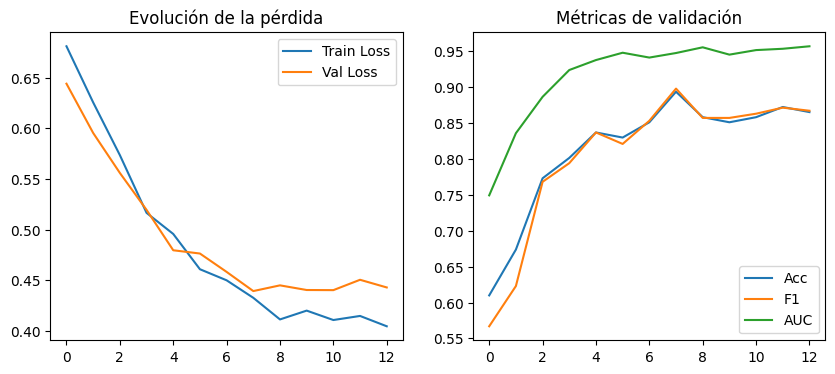

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import timm
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

model = timm.create_model('densenet121', pretrained=True, num_classes=2)

for param in model.parameters():
    param.requires_grad = True

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

NUM_EPOCHS = 25
PATIENCE = 5
best_val_loss = float('inf')
epochs_no_improve = 0

save_path = "/content/drive/MyDrive/IA/best_model_H2_Glaucoma.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []}

for epoch in range(NUM_EPOCHS):
    print(f"\n Epoch {epoch+1}/{NUM_EPOCHS}")
    model.train()
    train_loss = 0.0

    for imgs, labels in tqdm(train_loader, desc="Entrenando", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)
    scheduler.step()

    model.eval()
    val_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validando", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs)

    val_loss /= len(val_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(acc)
    history['val_f1'].append(f1)
    history['val_auc'].append(auc)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print(f"Mejor modelo actualizado y guardado en {save_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("⏹Early stopping activado.")
            break

print("\nEntrenamiento finalizado.")

# Métricas

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Evolución de la pérdida")

plt.subplot(1,2,2)
plt.plot(history['val_acc'], label='Acc')
plt.plot(history['val_f1'], label='F1')
plt.plot(history['val_auc'], label='AUC')
plt.legend(); plt.title("Métricas de validación")
plt.show()

E5 — Evaluación final + Matriz de Confusión + Grad-CAM

In [6]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Modelo cargado desde /content/drive/MyDrive/IA/best_model_H2_Glaucoma.pth


Evaluando modelo: 100%|██████████| 9/9 [00:11<00:00,  1.33s/it]


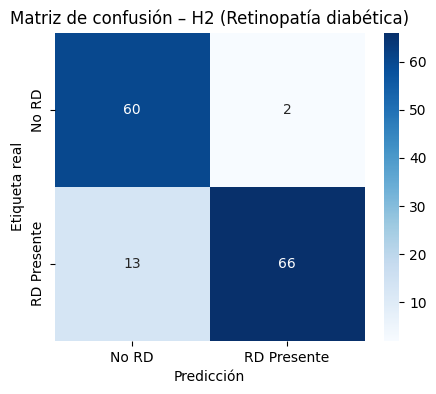


 Reporte de clasificación:
               precision    recall  f1-score   support

       No RD       0.82      0.97      0.89        62
 RD Presente       0.97      0.84      0.90        79

    accuracy                           0.89       141
   macro avg       0.90      0.90      0.89       141
weighted avg       0.91      0.89      0.89       141



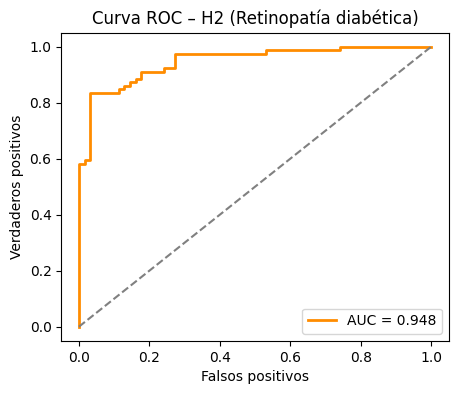

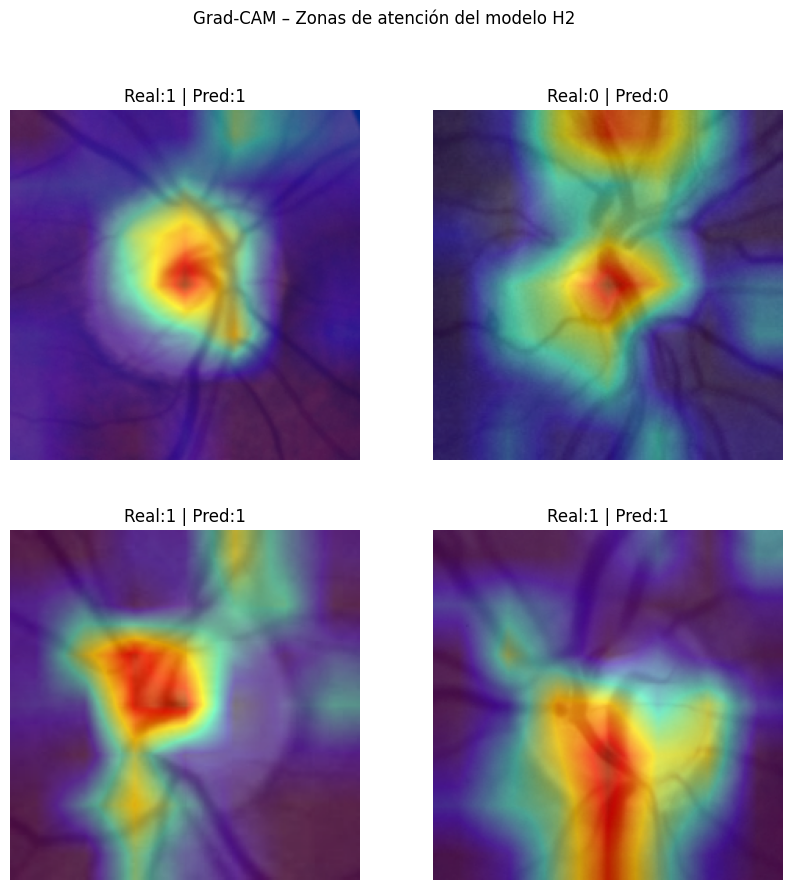

In [9]:
import torch, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from tqdm import tqdm

best_path = "/content/drive/MyDrive/IA/best_model_H2_Glaucoma.pth"
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()
print(f"Modelo cargado desde {best_path}")

all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Evaluando modelo"):
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        probs = torch.softmax(out, dim=1)[:,1].cpu().numpy()
        preds = torch.argmax(out, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()
        all_labels.extend(labels); all_preds.extend(preds); all_probs.extend(probs)

all_labels, all_preds, all_probs = map(np.array, [all_labels, all_preds, all_probs])

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No RD","RD Presente"],
            yticklabels=["No RD","RD Presente"])
plt.xlabel("Predicción"); plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión – H2 (Retinopatía diabética)")
plt.show()

# Métricas y curva ROC
print("\n Reporte de clasificación:\n",
      classification_report(all_labels, all_preds,
                            target_names=["No RD","RD Presente"]))
fpr,tpr,_ = roc_curve(all_labels,all_probs)
roc_auc = auc(fpr,tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr,tpr,lw=2,color="darkorange",label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("Falsos positivos"); plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC – H2 (Retinopatía diabética)")
plt.legend(); plt.show()

# Grad-CAM – Zonas activadas
idxs = np.random.choice(len(val_dataset), 4, replace=False)
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

plt.figure(figsize=(10,10))
for i,idx in enumerate(idxs):
    img_tensor,label = val_dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=[ClassifierOutputTarget(label)])[0]
    rgb = np.transpose(img_tensor.cpu().numpy(), (1,2,0))
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    vis = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)
    pred = model(input_tensor).argmax(1).item()
    plt.subplot(2,2,i+1); plt.imshow(vis)
    plt.title(f"Real:{label} | Pred:{pred}"); plt.axis("off")

plt.suptitle("Grad-CAM – Zonas de atención del modelo H2")
plt.show()